In [23]:
import logging
import threading
import itertools
#import modin.pandas as pd  
import pandas as pd
import numpy as np  
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import TelemanomScorer
#from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
#                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SpectralAnomalyScoreExt,
#                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
#                 KMeansAnomalyScoreV2, BayesRidgeRegressor, BayesRidgeRegressorExt)
#from mmfunctions.anomaly import (FeatureBuilder, GBMRegressor, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
from iotfunctions.anomaly import (BayesRidgeRegressorExt, GBMRegressor)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [24]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2022-05-25T19:07:11.887 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


### Prepare training data

In [25]:
#
# open real database to write trained models to the KPI_MODEL_STORE table
# 
from iotfunctions import dbtables
with open('/home/markus/src/mmfunctions/credentials_as_monitor31.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema='DEMO_MAM'
db_schema = None
db = Database(credentials=credentials)


2022-05-25T19:07:13.159 WARNING iotfunctions.db.__init__ Unable to locate CORE API URL.. using base API URL
2022-05-25T19:07:16.476 INFO iotfunctions.db.__init__ Data Dictionary is not available.


In [26]:
# check whether we're connected to the right database
db.connection

Engine(db2+ibm_db://admin:***@zen-cpd-zen.maximo31-14cc747866faab74c9640c8ac367af7f-0000.us-south.containers.appdomain.cloud:30952/db2wh1;)

In [27]:
#
# hard-coded: Entity type id for IOT_SOLAR, Schema 'DEMO_MAN'
#
db.model_store = dbtables.DBModelStore('demo', 5, 'DEMO_MAM', db.native_connection, db.db_type)

In [28]:
type(db.model_store.entity_type_id)

int

In [29]:
# original data for one of the panels
#
df_o1 = pd.read_csv('./data/INV1A_dataMOD2.csv', parse_dates=['datetime']).sort_values(by=['datetime'])
df_o2 = pd.read_csv('./data/INV1A_data2.csv', parse_dates=['datetime']).sort_values(by=['datetime'])
df_o3 = pd.read_csv('./data/INV1A_data3.csv', parse_dates=['date']).rename(columns={'date':'datetime'}).sort_values(by=['datetime'])

#df_input['entity'] = 'myentity'
#datetime,ROWID,AmbientTemperature_C,Inverter_Temperature_C,PanelTemperature_C,
#GlobalTiltedIrradiance_wm2,GlobalHorizontalIrradiance_wm2,Power_kW,Voltage_volt,Current_amp
#df_i = df_input.set_index(['entity','datetime']).drop(columns='ROWID')



In [41]:
#
# read mock data for training - must be replaced with original data
#
df_mod1 = pd.read_csv('./data/_MockupSolarData_Module1__202205201507.csv', parse_dates=['DATETIME']).sort_values(by='DATETIME')
df_mod2 = pd.read_csv('./data/_MockupSolarData_Module2__202205201507.csv', parse_dates=['DATETIME']).sort_values(by='DATETIME')
df_mod3 = pd.read_csv('./data/_MockupSolarData_Module3__202205201507.csv', parse_dates=['DATETIME']).sort_values(by='DATETIME')
df_mod4 = pd.read_csv('./data/_MockupSolarData_Module4__202205201508.csv', parse_dates=['DATETIME']).sort_values(by='DATETIME')
df_mod5 = pd.read_csv('./data/_MockupSolarData_Module5__202205201508.csv', parse_dates=['DATETIME']).sort_values(by='DATETIME')

### Plot distribution of mock up data

Text(0.5, 1.0, 'Mock Array 5')

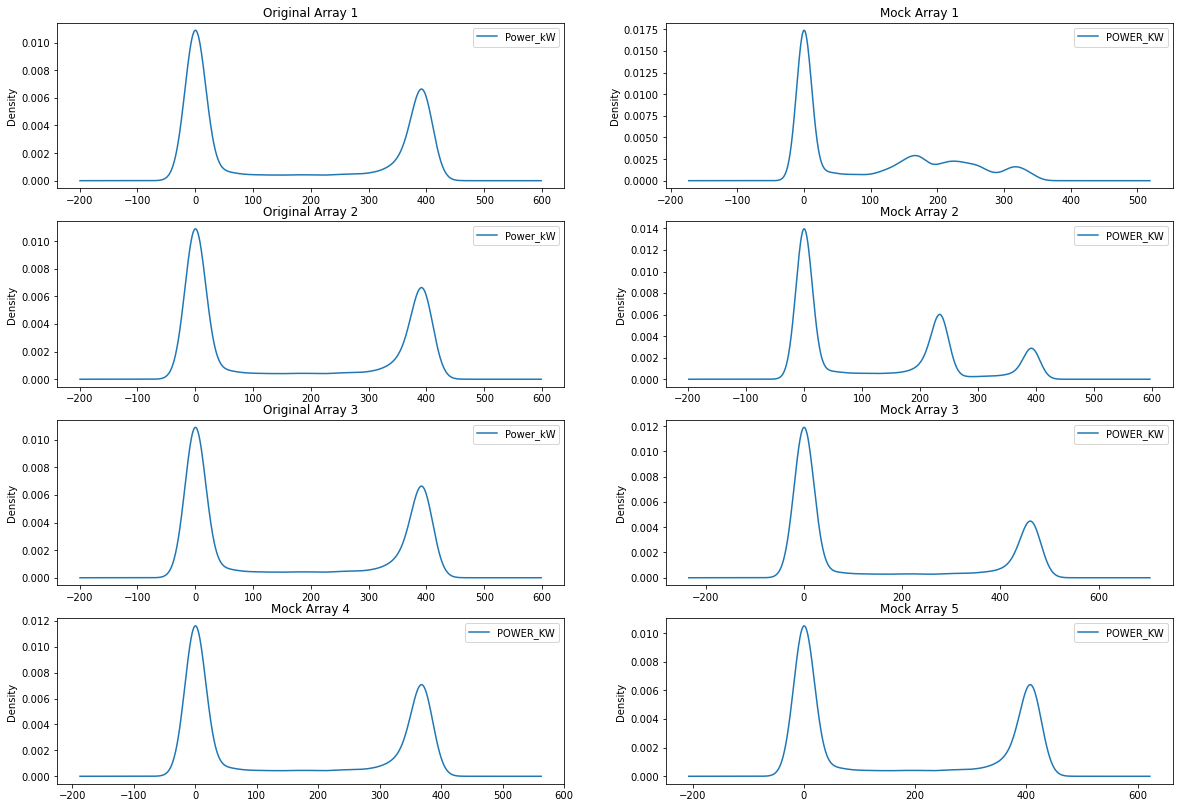

In [42]:
#
# investigate the mock up - plot distribution (KDE) 
#
bw = 0.1
fig, ax = plt.subplots(4,2,figsize=(20,14))

df_o1[['Power_kW']].plot(kind='kde', bw_method=bw, ax=ax[0,0])
ax[0,0].set_title('Original Array 1')
df_mod1[['POWER_KW']].plot(kind='kde', bw_method=bw, ax=ax[0,1])
ax[0,1].set_title('Mock Array 1')

df_o2[['Power_kW']].plot(kind='kde', bw_method=bw, ax=ax[1,0])
ax[1,0].set_title('Original Array 2')
df_mod2[['POWER_KW']].plot(kind='kde', bw_method=bw, ax=ax[1,1])
ax[1,1].set_title('Mock Array 2')

df_o3[['Power_kW']].plot(kind='kde', bw_method=bw, ax=ax[2,0])
ax[2,0].set_title('Original Array 3')
df_mod3[['POWER_KW']].plot(kind='kde', bw_method=bw, ax=ax[2,1])
ax[2,1].set_title('Mock Array 3')

df_mod4[['POWER_KW']].plot(kind='kde', bw_method=bw, ax=ax[3,0])
ax[3,0].set_title('Mock Array 4')
df_mod5[['POWER_KW']].plot(kind='kde', bw_method=bw, ax=ax[3,1])
ax[3,1].set_title('Mock Array 5')

In [43]:
#
# concatenate the mock up data to a single multi-indexed data frame for training
# 
df_mod1['entity'] = 'Array_1'
df_mod2['entity'] = 'Array_2'
df_mod3['entity'] = 'Array_3'
df_mod4['entity'] = 'Array_4'
df_mod5['entity'] = 'Array_5'
df = pd.concat([df_mod1, df_mod2, df_mod3, df_mod4, df_mod5]).set_index(['entity','DATETIME'])


In [44]:
df_o4 = df_o1.copy()
df_o5 = df_o1.copy()
df_o1['entity'] = 'Array_1'
df_o2['entity'] = 'Array_2'
df_o3['entity'] = 'Array_3'
df_o4['entity'] = 'Array_4'
df_o5['entity'] = 'Array_5'
df = pd.concat([df_o1, df_o2, df_o3, df_o4, df_o5]).set_index(['entity','datetime'])

In [45]:
df.columns

Index(['ROWID', 'AmbientTemperature_C', 'Inverter_Temperature_C',
       'PanelTemperature_C', 'GlobalTiltedIrradiance_wm2',
       'GlobalHorizontalIrradiance_wm2', 'Power_kW', 'Voltage_volt',
       'Current_amp'],
      dtype='object')

### Train model and save it in the database

In [21]:
#
# drive training script
#
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

EngineLogging.configure_console_logging(logging.DEBUG)

#telemanomScorer = TelemanomScorer(['POWER_KW','GLOBALHORIZONTALIRRADIANCE_WM2','GLOBALTILTEDIRRADIANCE_WM2'], 1,
#                           'pred_LSTM_power','anomaly_score')
telemanomScorer = TelemanomScorer(['Power_kW','GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2'], 1,
                           'pred_LSTM_power','anomaly_score')

#telemanomScorer.delete_model = True
telemanomScorer.l_s = 120
telemanomScorer.epochs = 35
telemanomScorer.execute_by = ['entity']

et = telemanomScorer._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
et.name = 'IOT_SOLAR'

telemanomScorer._entity_type = et
telemanomScorer.train(df)

2022-05-25T15:03:14.348 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-05-25T15:03:14.349 DEBUG root.__init__ __init__SupervisedLearningTransformer
2022-05-25T15:03:14.349 DEBUG root.__init__ __init__ done with parameters: Power_kW.GlobalHorizontalIrradiance_wm2.GlobalTiltedIrradiance_wm2.pred_LSTM_power.anomaly_score
2022-05-25T15:03:14.349 INFO mmfunctions.anomaly.__init__ TelemanomScorer features: ['Power_kW', 'GlobalHorizontalIrradiance_wm2', 'GlobalTiltedIrradiance_wm2'] targets: ['pred_LSTM_power', 'anomaly_score']
2022-05-25T15:03:14.350 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.7.0
2022-05-25T15:03:14.350 DEBUG iotfunctions.util.__init__ Starting trace
2022-05-25T15:03:14.351 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_TelemanomScorer_20220525130314
2022-05-25T15:03:14.352 DEBUG iotfunctions.util.__init__ auto_save None
2022-05-25T15:03:14.352 DE

/home/markus/.local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(6426, 3)
Epoch 1/35
63/63 [==============================] - 11s 135ms/step - loss: 0.1661 - mean_squared_error: 0.1661 - val_loss: 0.0656 - val_mean_squared_error: 0.0656
Epoch 2/35
63/63 [==============================] - 8s 125ms/step - loss: 0.0769 - mean_squared_error: 0.0769 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 3/35
63/63 [==============================] - 8s 130ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 4/35
63/63 [==============================] - 8s 127ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 5/35
63/63 [==============================] - 8s 129ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 6/35
63/63 [==============================] - 8s 128ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 7/35
63/63 

/home/markus/.local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(6426, 3)
Epoch 1/35
63/63 [==============================] - 11s 138ms/step - loss: 0.1659 - mean_squared_error: 0.1356 - val_loss: 0.0699 - val_mean_squared_error: 0.0699
Epoch 2/35
63/63 [==============================] - 8s 129ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 3/35
63/63 [==============================] - 9s 138ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 4/35
63/63 [==============================] - 9s 144ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 5/35
63/63 [==============================] - 8s 132ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 6/35
63/63 [==============================] - 8s 135ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 7/35
63/63 

/home/markus/.local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(6426, 3)
Epoch 1/35
63/63 [==============================] - 11s 146ms/step - loss: 0.1707 - mean_squared_error: 0.1407 - val_loss: 0.0730 - val_mean_squared_error: 0.0730
Epoch 2/35
63/63 [==============================] - 8s 130ms/step - loss: 0.0794 - mean_squared_error: 0.0794 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 3/35
63/63 [==============================] - 8s 126ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 4/35
63/63 [==============================] - 8s 124ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 5/35
63/63 [==============================] - 8s 133ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 6/35
63/63 [==============================] - 9s 137ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 7/35
63/63 

/home/markus/.local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(6426, 3)
Epoch 1/35
63/63 [==============================] - 12s 149ms/step - loss: 0.1741 - mean_squared_error: 0.1433 - val_loss: 0.0693 - val_mean_squared_error: 0.0693
Epoch 2/35
63/63 [==============================] - 8s 134ms/step - loss: 0.0778 - mean_squared_error: 0.0778 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 3/35
63/63 [==============================] - 8s 135ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 4/35
63/63 [==============================] - 8s 133ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 5/35
63/63 [==============================] - 9s 139ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 6/35
63/63 [==============================] - 9s 138ms/step - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 7/35
63/63 

/home/markus/.local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(6426, 3)
Epoch 1/35
63/63 [==============================] - 11s 141ms/step - loss: 0.1812 - mean_squared_error: 0.1477 - val_loss: 0.0651 - val_mean_squared_error: 0.0651
Epoch 2/35
63/63 [==============================] - 9s 137ms/step - loss: 0.0759 - mean_squared_error: 0.0759 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 3/35
63/63 [==============================] - 8s 135ms/step - loss: 0.0545 - mean_squared_error: 0.0545 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 4/35
63/63 [==============================] - 8s 134ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 5/35
63/63 [==============================] - 8s 127ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 6/35
63/63 [==============================] - 8s 134ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 7/35
63/63 

ROWID  AmbientTemperature_C  \
entity  datetime                                            
Array_1 2020-01-06 00:00:00  1140.0             13.876353   
        2020-01-06 00:05:00  1141.0             13.897960   
        2020-01-06 00:10:00  1142.0             13.919568   
        2020-01-06 00:15:00  1143.0             13.941175   
        2020-01-06 00:20:00  1144.0             13.962783   
...                             ...                   ...   
Array_5 2020-12-06 23:35:00  4591.0             18.938465   
        2020-12-06 23:40:00  4592.0             18.911510   
        2020-12-06 23:45:00  4593.0             18.884555   
        2020-12-06 23:50:00  4594.0             18.857600   
        2020-12-06 23:55:00  4595.0             18.830645   

                             Inverter_Temperature_C  PanelTemperature_C  \
entity  datetime                                                          
Array_1 2020-01-06 00:00:00               13.876353           13.876353   
        2020-01-06 00:05:00               13.897960           13.897960   
        2020-01-06 00:10:00               13.919568           13.919568   
        2020-01-06 00:15:00               13.941175           13.941175   
        2020-01-06 00:20:00               13.962783           13.962783   
...                                             ...                 ...   
Array_5 2020-12-06 23:35:00               18.938465           18.938465   
        2020-12-06 23:40:00               18.911510           18.911510   
        2020-12-06 23:45:00               18.884555           18.884555   
        2020-12-06 23:50:00               18.857600           18.857600   
        2020-12-06 23:55:00               18.830645           18.830645   

                             GlobalTiltedIrradiance_wm2  \
entity  datetime                                          
Array_1 2020-01-06 00:00:00                         0.0   
        2020-01-06 00:05:00                         0.0   
        2020-01-06 00:10:00                         0.0   
        2020-01-06 00:15:00                         0.0   
        2020-01-06 00:20:00                         0.0   
...                                                 ...   
Array_5 2020-12-06 23:35:00                         0.0   
        2020-12-06 23:40:00                         0.0   
        2020-12-06 23:45:00                         0.0   
        2020-12-06 23:50:00                         0.0   
        2020-12-06 23:55:00                         0.0   

                             GlobalHorizontalIrradiance_wm2  Power_kW  \
entity  datetime                                                        
Array_1 2020-01-06 00:00:00                             0.0       0.0   
        2020-01-06 00:05:00                             0.0       0.0   
        2020-01-06 00:10:00                             0.0       0.0   
        2020-01-06 00:15:00                             0.0       0.0   
        2020-01-06 00:20:00                             0.0       0.0   
...                                                     ...       ...   
Array_5 2020-12-06 23:35:00                             0.0       0.0   
        2020-12-06 23:40:00                             0.0       0.0   
        2020-12-06 23:45:00                             0.0       0.0   
        2020-12-06 23:50:00                             0.0       0.0   
        2020-12-06 23:55:00                             0.0       0.0   

                             Voltage_volt  Current_amp  
entity  datetime                                        
Array_1 2020-01-06 00:00:00           0.0          0.0  
        2020-01-06 00:05:00           0.0          0.0  
        2020-01-06 00:10:00           0.0          0.0  
        2020-01-06 00:15:00           0.0          0.0  
        2020-01-06 00:20:00           0.0          0.0  
...                                   ...          ...  
Array_5 2020-12-06 23:35:00           0.0          0.0  
        2020-12-06 23:40:00  

### Temperature vs Power

Text(0.5, 1.0, 'Mock Array 5')

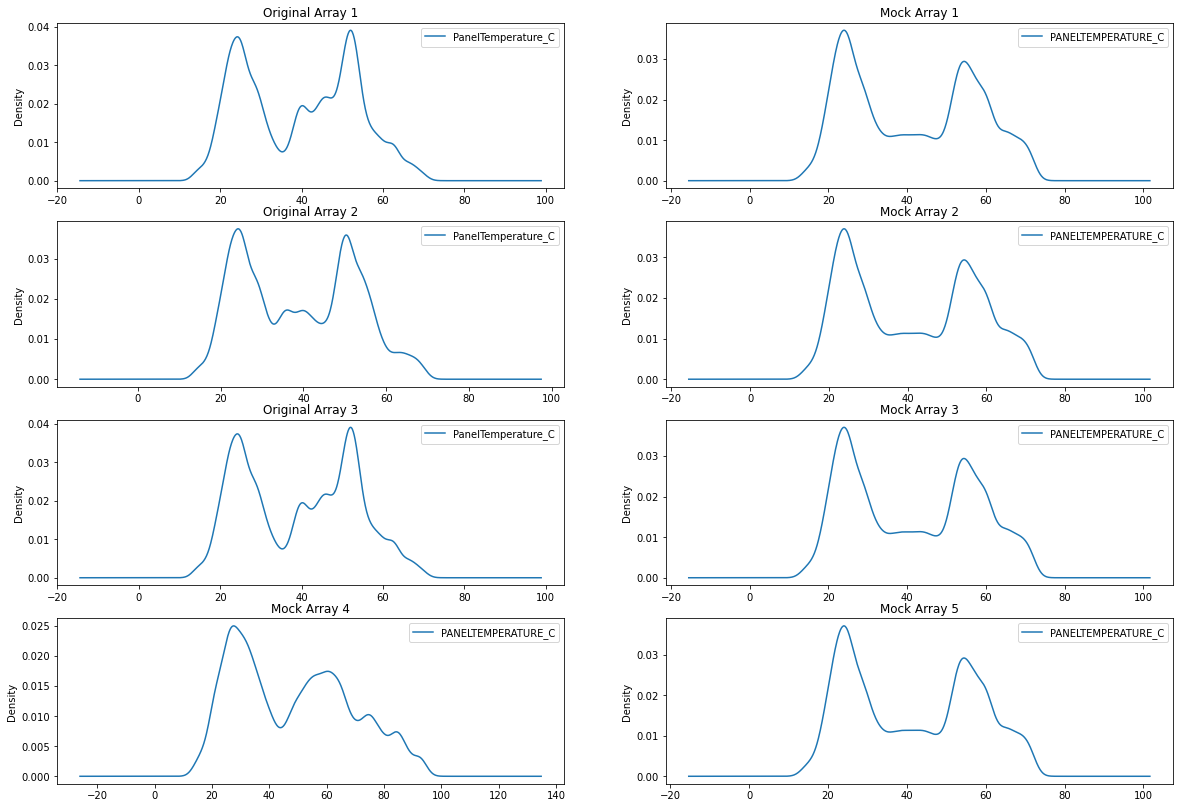

In [31]:
bw = 0.1
column = 'PanelTemperature_C'
Column = 'PANELTEMPERATURE_C'
fig, ax = plt.subplots(4,2,figsize=(20,14))

df_o1[[column]].plot(kind='kde', bw_method=bw, ax=ax[0,0])
ax[0,0].set_title('Original Array 1')
df_mod1[[Column]].plot(kind='kde', bw_method=bw, ax=ax[0,1])
ax[0,1].set_title('Mock Array 1')

df_o2[[column]].plot(kind='kde', bw_method=bw, ax=ax[1,0])
ax[1,0].set_title('Original Array 2')
df_mod2[[Column]].plot(kind='kde', bw_method=bw, ax=ax[1,1])
ax[1,1].set_title('Mock Array 2')

df_o3[[column]].plot(kind='kde', bw_method=bw, ax=ax[2,0])
ax[2,0].set_title('Original Array 3')
df_mod3[[Column]].plot(kind='kde', bw_method=bw, ax=ax[2,1])
ax[2,1].set_title('Mock Array 3')

df_mod4[[Column]].plot(kind='kde', bw_method=bw, ax=ax[3,0])
ax[3,0].set_title('Mock Array 4')
df_mod5[[Column]].plot(kind='kde', bw_method=bw, ax=ax[3,1])
ax[3,1].set_title('Mock Array 5')

In [32]:
df_o1[['PanelTemperature_C','GlobalTiltedIrradiance_wm2','Power_kW']].corr(method='spearman')

,PanelTemperature_C,GlobalTiltedIrradiance_wm2,Power_kW
PanelTemperature_C,1.000000,0.879268,0.853453
GlobalTiltedIrradiance_wm2,0.879268,1.000000,0.969457
Power_kW,0.853453,0.969457,1.000000


In [35]:
df_mod1[['PANELTEMPERATURE_C','GLOBALTILTEDIRRADIANCE_WM2','POWER_KW']].corr(method='spearman')

,PANELTEMPERATURE_C,GLOBALTILTEDIRRADIANCE_WM2,POWER_KW
PANELTEMPERATURE_C,1.000000,0.876704,0.800174
GLOBALTILTEDIRRADIANCE_WM2,0.876704,1.000000,0.911879
POWER_KW,0.800174,0.911879,1.000000


In [38]:
Temperature = 'PanelTemperature_C'
from mmfunctions.anomaly import GMMAnomalyScore
#EngineLogging.configure_console_logging(logging.DEBUG)
gmm1 = GMMAnomalyScore(Temperature, 2, 3, 'gmm')
gmm1.delete_model = True
#et = gmm1._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
et = gmm1._build_entity_type(**jobsettings)
gmm1._entity_type = et
df = gmm1.execute(df=df)

2022-05-25T19:26:40.550 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-05-25T19:26:41.659 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GMMANOMALYSCORE.GMMAnomalyScore.gmm.Array_1 does not exist in table "DEMO_MAM"."KPI_MODEL_STORE"
Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True
2022-05-25T19:26:42.209 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_GMMANOMALYSCORE.GMMAnomalyScore.gmm.Array_1 of size 1919 bytes has been stored in table "DEMO_MAM"."KPI_MODEL_STORE".
(12528, 1) (12528, 1)
2022-05-25T19:26:42.944 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GMMANOMALYSCORE.GMMAnomalyScore.gmm.Array_2 does not exist in table "DEMO_MAM"."KPI_MODEL_STORE"
Initialization 0
Initializati

In [40]:
df.columns

Index(['ROWID', 'AmbientTemperature_C', 'Inverter_Temperature_C',
       'PanelTemperature_C', 'GlobalTiltedIrradiance_wm2',
       'GlobalHorizontalIrradiance_wm2', 'Power_kW', 'Voltage_volt',
       'Current_amp', 'gmm'],
      dtype='object')

In [33]:
df_mod1.columns

Index(['DATETIME', 'ROWID', 'CURRENT_AMP', 'VOLTAGE_VOLT', 'POWER_KW',
       'PANELTEMPERATURE_C', 'INVERTER_TEMPERATURE_C', 'AMBIENTTEMPERATURE_C',
       'GLOBALTILTEDIRRADIANCE_WM2', 'GLOBALHORIZONTALIRRADIANCE_WM2',
       'MODULE_ALL_TOTALPOWER_KW'],
      dtype='object')

<AxesSubplot:ylabel='Density'>

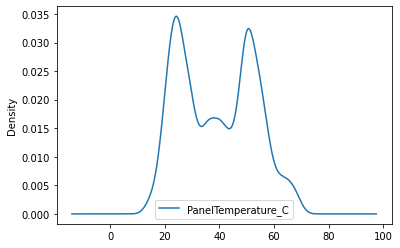

In [32]:
df_o2[['PanelTemperature_C']].plot(kind='kde')

### More stuff


In [9]:
arr_i = df_i['Inverter_Temperature_C'].values
arr_iz = np.full(arr_i.shape, 'Inverter')
arr_p = df_i['PanelTemperature_C'].values
arr_pz = np.full(arr_p.shape, 'Panel')
df_2 = pd.DataFrame(np.hstack([np.vstack([arr_i, arr_iz]), 
                               np.vstack([arr_p, arr_pz])
                              ]).T)
df_2 = df_2.rename(columns={0: 'temperature', 1: 'descriptor'})
df_2['temperature'] = df_2['temperature'].astype(float)

<AxesSubplot:xlabel='temperature', ylabel='Density'>

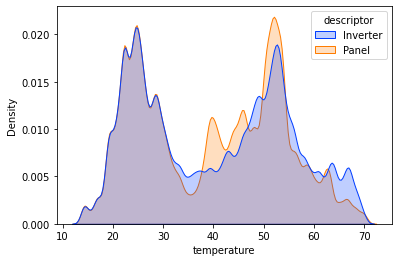

In [10]:
sns.kdeplot(data=df_2, x='temperature', hue='descriptor', shade=True,
             bw_adjust=.3, fill=True, palette=sns.color_palette('bright')[:2])

<AxesSubplot:ylabel='Count'>

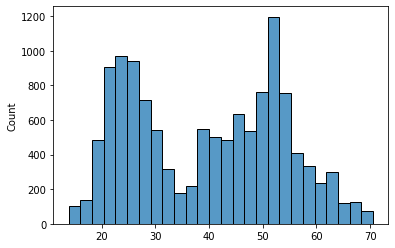

In [11]:
sns.histplot(df_i['PanelTemperature_C'].values)

In [12]:
df_i.loc['myentity'][['GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2','Power_kW']][0:2]

,GlobalHorizontalIrradiance_wm2,GlobalTiltedIrradiance_wm2,Power_kW
datetime,,,
2020-01-06 00:00:00,0.0,0.0,0.0
2020-01-06 00:05:00,0.0,0.0,0.0


<AxesSubplot:xlabel='datetime'>

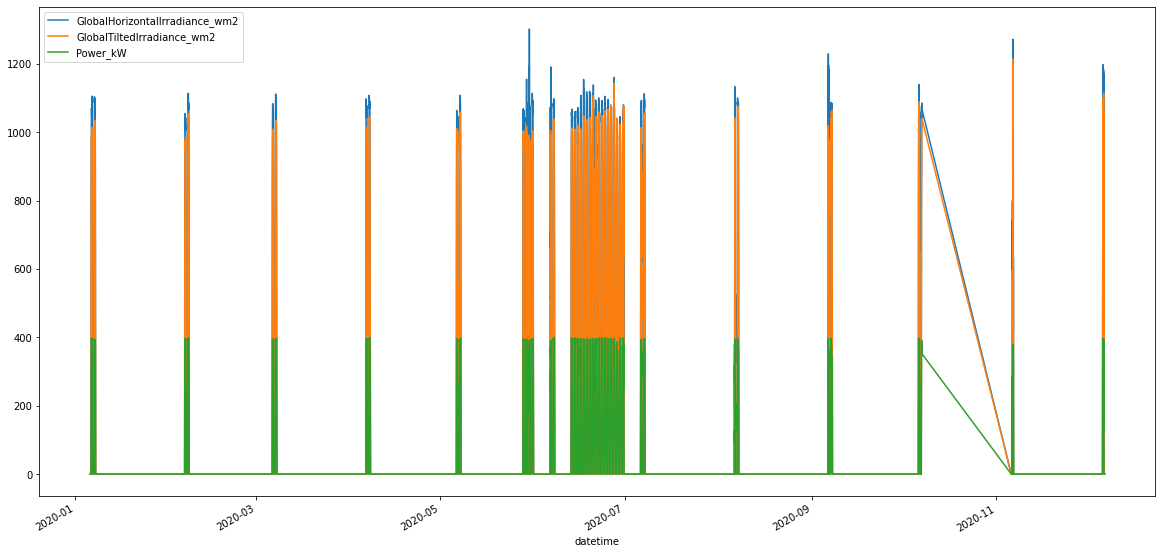

In [13]:
df_i.loc['myentity'][['GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2','Power_kW']].plot(figsize=(20,10))

In [14]:
df_daylight = df_i[df_i['Power_kW'] > 0]

<AxesSubplot:>

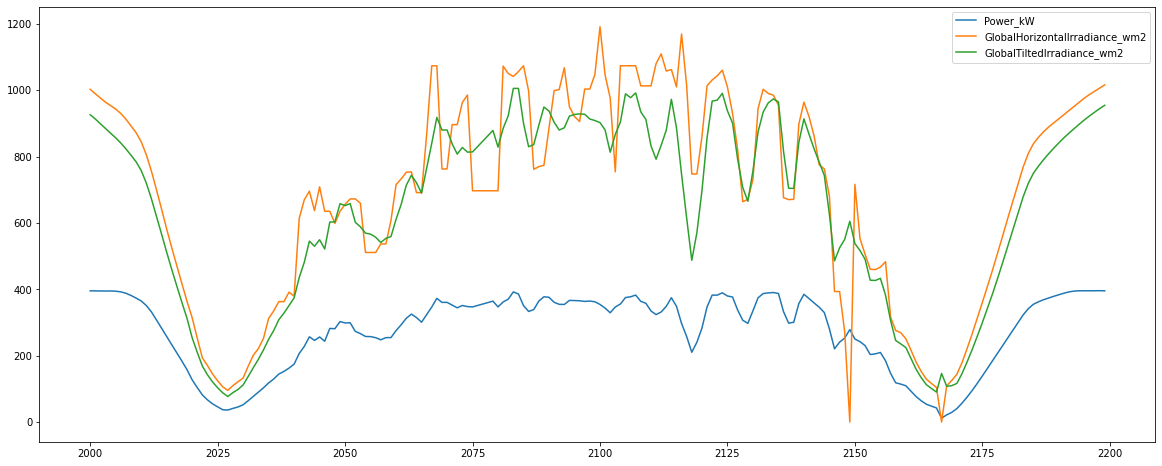

In [15]:
df_daylight.reset_index()[['Power_kW','GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2']][2000:2200].plot(figsize=(20,8))

In [16]:
df_daylight['Power_kW'].values.shape

(6426,)

In [17]:
dti = pd.date_range("2018-01-01", periods=df_daylight['Power_kW'].values.shape[0], freq="H")
df_dl = pd.DataFrame(df_daylight['Power_kW'].values)
df_dl['datetime'] = pd.date_range("2018-01-01", periods=df_daylight['Power_kW'].values.shape[0], freq="H")
df_dl['Power_kW'] = df_daylight['Power_kW'].values
df_dl['GlobalTiltedIrradiance_wm2'] = df_daylight['GlobalTiltedIrradiance_wm2'].values
df_dl['GlobalHorizontalIrradiance_wm2'] = df_daylight['GlobalHorizontalIrradiance_wm2'].values
df_dl['entity'] = 'myentity'
df_dl = df_dl.set_index(['entity','datetime'])

In [18]:
df_dl

0   Power_kW  \
entity   datetime                                    
myentity 2018-01-01 00:00:00  16.341553  16.341553   
         2018-01-01 01:00:00  23.366211  23.366211   
         2018-01-01 02:00:00  27.442627  27.442627   
         2018-01-01 03:00:00  41.149414  41.149414   
         2018-01-01 04:00:00  50.114746  50.114746   
...                                 ...        ...   
         2018-09-25 13:00:00  54.714355  54.714355   
         2018-09-25 14:00:00  48.624512  48.624512   
         2018-09-25 15:00:00  44.291504  44.291504   
         2018-09-25 16:00:00  41.373047  41.373047   
         2018-09-25 17:00:00  39.136230  39.136230   

                              GlobalTiltedIrradiance_wm2  \
entity   datetime                                          
myentity 2018-01-01 00:00:00                  114.016602   
         2018-01-01 01:00:00                  105.272461   
         2018-01-01 02:00:00                  107.577148   
         2018-01-01 03:00:00                  115.522461   
         2018-01-01 04:00:00                  133.152344   
...                                                  ...   
         2018-09-25 13:00:00                  109.434570   
         2018-09-25 14:00:00                   97.168945   
         2018-09-25 15:00:00                   88.531250   
         2018-09-25 16:00:00                   82.607422   
         2018-09-25 17:00:00                   77.625000   

                              GlobalHorizontalIrradiance_wm2  
entity   datetime                                             
myentity 2018-01-01 00:00:00                      137.765625  
         2018-01-01 01:00:00                      127.087891  
         2018-01-01 02:00:00                      131.332031  
         2018-01-01 03:00:00                      143.238281  
         2018-01-01 04:00:00                      173.509766  
...                                                      ...  
         2018-09-25 13:00:00                      129.585938  
         2018-09-25 14:00:00                      115.270508  
         2018-09-25 15:00:00                      105.145508  
         2018-09-25 16:00:00                       98.184570  
         2018-09-25 17:00:00                       92.378906  

[6426 rows x 4 columns]

In [19]:
def testtest(x):
    return x.sum()

t = df_daylight.groupby([pd.Grouper(level='entity'), pd.Grouper(level='datetime',freq='H')]).apply(sum)

#data.resample('H', on='created_at').agg({'price':'sum', 'quantity':'sum','item_code':'nunique'})

<AxesSubplot:xlabel='datetime'>

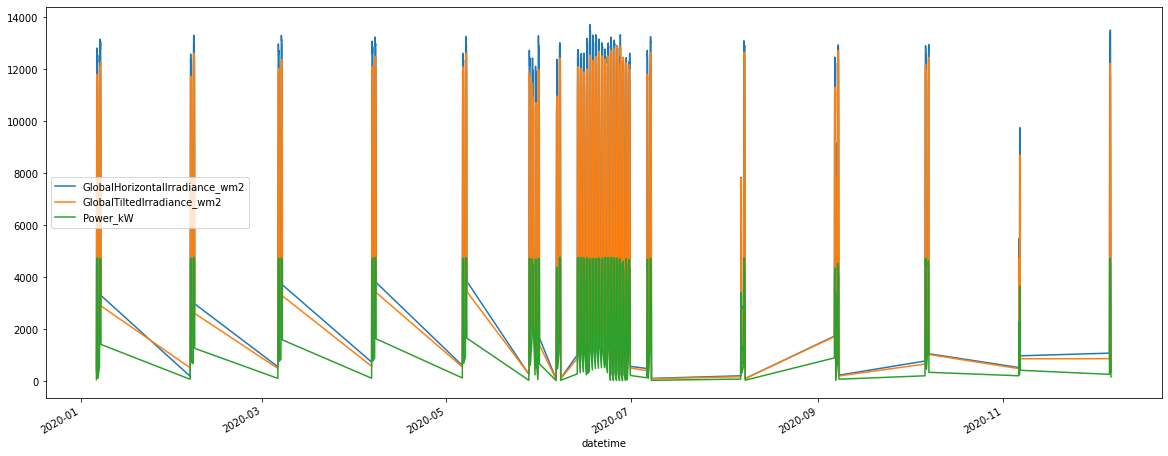

In [20]:
t.loc['myentity'][['GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2','Power_kW']].plot(figsize=(20,8))


In [21]:
# part of mmfunctions
import telemanom
from telemanom.helpers import Config
from telemanom.errors import Errors
import telemanom.helpers as helpers
from telemanom.channel import Channel
from telemanom.modeling import Model

conf = Config("./telemanom/config.yaml")

list_attr=['Power_kW','GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2']
#list_attr=['vibrations','accel_power_0']
conf.dictionary['l_s'] = 80
conf.dictionary['epochs'] = 80
conf.dictionary['dropout'] = 0.2
conf.l_s = 80
# conf.epochs = 80
conf.dropout = 0.2
conf.lstm_batch_size=80

In [22]:
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
scal = MinMaxScaler()
scal.fit(df_daylight[list_attr].values)

MinMaxScaler()

In [23]:
# scale higher (*2) to make it a bit harder on the training run
'''
tel_input = scal.transform(df_daylight[list_attr].values)
tel_inputb = scal.transform(df_daylight[list_attr].values)
np.save("telemanom/data/train/Armstarknew.npy", tel_input)
np.save("telemanom/data/test/Armstarknew.npy", tel_inputb)
'''

'\ntel_input = scal.transform(df_daylight[list_attr].values)\ntel_inputb = scal.transform(df_daylight[list_attr].values)\nnp.save("telemanom/data/train/Armstarknew.npy", tel_input)\nnp.save("telemanom/data/test/Armstarknew.npy", tel_inputb)\n'

In [24]:
from mmfunctions.anomaly import TelemanomScorer

In [25]:
from telemanom.detector import Detector
detector = Detector(result_path='results/', config_path='config.yaml', Path='./telemanom/')
detector.config.predict = False
#model_list = detector.run()

FileNotFoundError: [Errno 2] No such file or directory: './telemanom/data/test/'

In [26]:
#model_list[0].model.history

In [27]:
# Load data from 
device="Armstarknew"
chan = Channel(conf, device)
helpers.make_dirs(conf.use_id, conf, "./telemanom")
print(chan)
print(conf.l_s)


Channel:Channel
80


In [28]:
#chan.delete_data("./telemanom")
#chan.load_data("./telemanom")
chan.train = df_daylight[list_attr].values
chan.test = df_daylight[list_attr].values

# chan.train
dfA = pd.DataFrame(chan.train)
dfA.describe()

,0,1,2
count,6426.000000,6426.000000,6426.000000
mean,322.691299,846.079713,795.419029
std,111.528612,312.851639,301.525684
min,11.633789,0.000000,75.495117
25%,291.208008,691.857422,638.001953
50%,387.419922,1012.105469,952.910156
75%,394.343750,1067.656250,1017.177735
max,398.921875,1302.406250,1213.953125


In [29]:
chan.train.shape

(6426, 3)

In [30]:
# producing overlapping windows of length 260 for lookback (250) and prediction (10)
chan.shape_data(chan.train, train=True)

(6426, 3)


In [31]:
chan.scaler

MinMaxScaler()

In [32]:
# init the Keras double stacked LSTM model
model = Model(conf, conf.use_id, Channel=chan, Path="./telemanom", Train=False)

In [33]:
# drink a coffee - training takes roughly 7 minutes
model.train_new(chan)
#model.load("./telemanom")

Epoch 1/35
64/64 [==============================] - 10s 107ms/step - loss: 0.1869 - mean_squared_error: 0.1869 - val_loss: 0.0674 - val_mean_squared_error: 0.0674
Epoch 2/35
64/64 [==============================] - 7s 108ms/step - loss: 0.0793 - mean_squared_error: 0.0793 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 3/35
64/64 [==============================] - 9s 136ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 4/35
64/64 [==============================] - 9s 147ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 5/35
64/64 [==============================] - 9s 137ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 6/35
64/64 [==============================] - 9s 140ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 7/35
64/64 [=========

<AxesSubplot:>

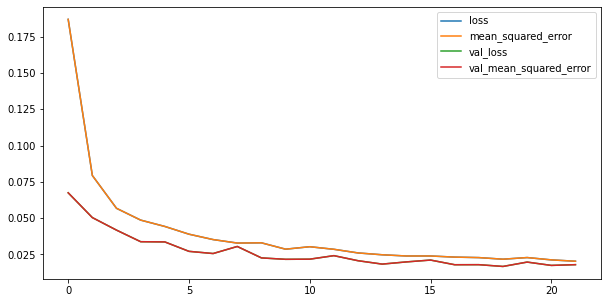

In [34]:
pd.DataFrame(model.history.history).plot(figsize=(10,5))


In [35]:
model.model.save('/tmp/solar.h5')
f1 = open('/tmp/solar.h5', "rb")
model_h5 = f1.read()
f1.close()

model2 = (model_h5, model.scaler, model.config, model.history.history)


In [36]:
chan.id, chan.X_train.shape[2],model.run_id, model.config.use_id

('Armstarknew', 3, '2020-01-29_15.00.10', '2020-01-29_15.00.10')

In [37]:


import dill as pickle
f = open("/tmp/solarmodel.bin", "wb")
f.write(pickle.dumps(model2))
f.close()


In [5]:
import dill as pickle
#f1 = open("./data/solarmodel.bin", "rb")
f1 = open("./KPI_MODEL_STOREmodel.TEST_ENTITY_FOR_TELEMANOMSCORER.SupervisedLearningTransformer.pred_Power_kW.anom_Power_kW.myentity","rb")
model2 = f1.read()
f1.close()
model3 = pickle.loads(model2)

In [12]:
model2a = bytes(bytes(model2))
print(type(model2), type(model2a))

<class 'bytes'> <class 'bytes'>


In [16]:
model3.model

In [10]:
model2b = model2a.decode()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [64]:
#errors.process_batches(chan)

In [38]:
chan.shape_data(chan.test, train=False)

(6426, 3)


In [39]:
# predicting takes roughly 12 secs
model.batch_predict(chan, Path="./telemanom")

In [40]:
# smooth the prediction error and apply exponential weights to it
errors = Errors(chan, conf, conf.use_id, "./telemanom")

#  for each overlapping window establish a threshold so that removing error points above it 
# maximizes the reduction of mean and standard deviation. Sort of an adaptive z-score 
errors.process_batches(chan)

normalized prediction error: 0.04
2022-05-19T11:49:52.919 INFO telemanom.__init__ normalized prediction error: 0.04
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


In [41]:
print (errors.E_seq, " \n ", errors.anom_scores)

[(1637, 1913), (5180, 5348), (5380, 5943), (6180, 6279), (6302, 6401)]  
  [{'start_idx': 1557, 'end_idx': 1833, 'score': 6.216455561401885}, {'start_idx': 5100, 'end_idx': 5199, 'score': 4.24616182342584}, {'start_idx': 5200, 'end_idx': 5268, 'score': 3.9006682358940523}, {'start_idx': 5300, 'end_idx': 5399, 'score': 4.960579872703563}, {'start_idx': 5400, 'end_idx': 5499, 'score': 4.816539181690447}, {'start_idx': 5500, 'end_idx': 5599, 'score': 4.606031941510334}, {'start_idx': 5600, 'end_idx': 5699, 'score': 6.0473035663136825}, {'start_idx': 5700, 'end_idx': 5799, 'score': 6.206587912478421}, {'start_idx': 5800, 'end_idx': 5863, 'score': 5.537251337759423}, {'start_idx': 6100, 'end_idx': 6199, 'score': 6.095974630237401}, {'start_idx': 6222, 'end_idx': 6321, 'score': 5.986004808612169}]


In [49]:
model.save("./telemanom")

In [42]:
# How good are we doing ?

model.model.evaluate(chan.X_test, chan.y_test)

198/198 [==============================] - 3s 16ms/step - loss: 0.0166 - mean_squared_error: 0.0166


[0.016622096300125122, 0.016622096300125122]

In [45]:
chan.scaler.inverse_transform(chan.X_test[:,model.config.l_s-1,:])

array([[ 393.8164063, 1040.53125  ,  964.171875 ],
       [ 393.8515625, 1035.828125 ,  962.734375 ],
       [ 393.7460938, 1035.703125 ,  963.296875 ],
       ...,
       [ 180.015625 ,  345.8554688,  385.5976563],
       [ 262.0625   ,  491.2382813,  545.171875 ],
       [ 285.71875  ,  594.2109375,  588.3125   ]])

In [46]:
chan.test

array([[ 16.34155273, 137.765625  , 114.0166016 ],
       [ 23.36621094, 127.0878906 , 105.2724609 ],
       [ 27.44262695, 131.3320313 , 107.5771484 ],
       ...,
       [ 44.29150391, 105.1455078 ,  88.53125   ],
       [ 41.37304688,  98.18457031,  82.60742188],
       [ 39.13623047,  92.37890625,  77.625     ]])

In [250]:
arr_2 = np.vstack([chan.y_test[:,0], chan.y_test[:,0], chan.y_test[:,0]]).T
arr_2[:,2:].shape

(6152, 1)

In [242]:
arr_test = chan.scaler.inverse_transform(chan.y_test[:,0].reshape(-1,1))
arr_test = chan.scaler1.inverse_transform(np.vstack([chan.y_test[:,0], chan.y_test[:,0], chan.y_test[:,0]]).T)
#arr_test = chan.scaler1.inverse_transform(chan.y_test)
arr_hat = (chan.y_hat.reshape(-1,1))
arr_hat = chan.scaler.inverse_transform(arr_hat)
arr_hat = chan.scaler1.inverse_transform(np.hstack([arr_hat, arr_hat, arr_hat]))
arr_hat = arr_hat[:,0]
#arr_hat = chan.scaler1.inverse_transform(np.vstack([arr_hat, arr_hat, arr_hat]).T)
print(arr_test.shape, arr_hat.shape)

(6152, 3) (6152,)


Text(0.5, 1.0, 'Power generation - input')

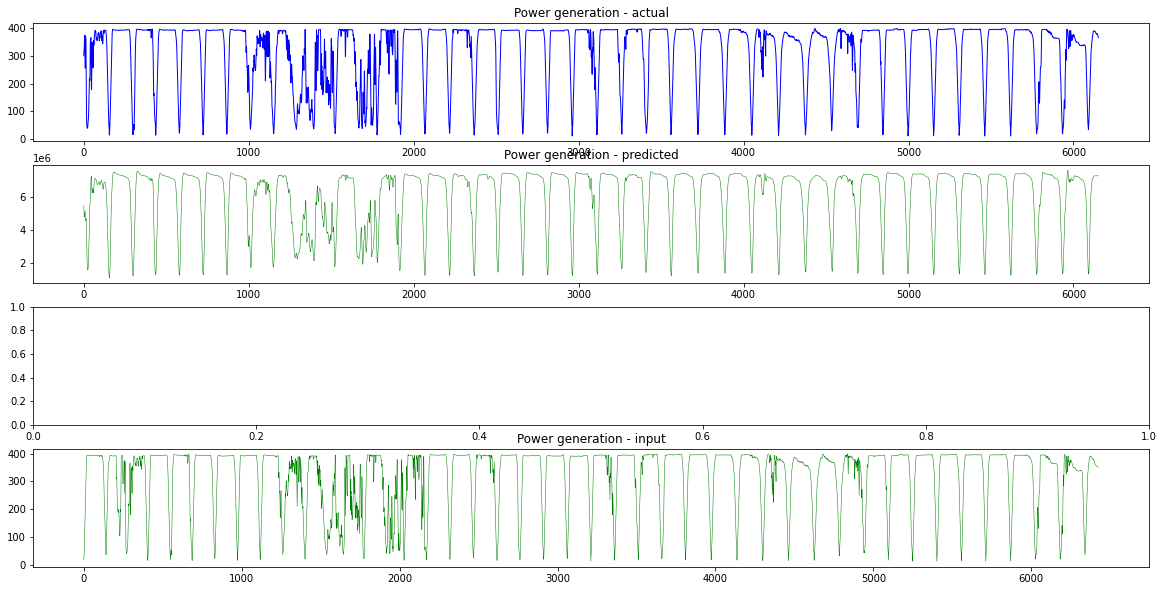

In [243]:

fig, ax = plt.subplots(4, 1, figsize=(20, 10))
#ax[0].plot(chan.y_train_hat[:8200] * 10, lw=0.2, color='green')  # to be done
ax[0].plot(arr_test[:,0], lw=1, color='blue', label='power')
ax[0].set_title('Power generation - actual')
ax[1].plot(arr_hat, lw=0.5, color='green')
ax[1].set_title('Power generation - predicted')
#ax[2].plot(abs(arr_hat - arr_test[:,0]), lw=0.5, color='red')
#ax[2].set_title('Power generation - predicted - actual')
ax[3].plot(chan.test[:,0], lw=0.5, color='green')
ax[3].set_title('Power generation - input')

In [57]:
threshold = 1

from mmfunctions.anomaly import SupervisedLearningTransformer
logger = logging.getLogger(__name__)
class TelemanomScorer(SupervisedLearningTransformer):                                                                                        
                                                                                                                                             
    def __init__(self, input_items, output_items):                                                                                           
                                                                                                                                             
        features = input_items                                                                                                               
        if not isinstance(input_items, list):                                                                                                
            features = [input_items]                                                                                                         
        targets = output_items                                                                                                               
        if not isinstance(output_items, list):                                                                                               
            targets = [output_items]                                                                                                         
        super().__init__(features=features, targets=targets)                                                                                 
                                                                                                                                             
        self.auto_train = True                                                                                                               
        #self.config = Config("./telemanom/config.yaml")                                                                                      
                                                                                                                                             
        self.whoami = 'TelemanomScorer'                                                                                                      
                                                                                                                                             
        logger.info(self.whoami + ' features: ' + str(self.features) + ' targets: ' +  str(self.targets))
        
    def execute(self, df):                                                                                                                   
        # set output columns to zero                                                                                                         
        logger.debug('Called ' + self.whoami + ' with columns: ' + str(df.columns))
        df_copy = df.copy()
        df_copy[self.targets[0]] = 0
        df_copy[self.targets[1]] = np.nan
        return super().execute(df_copy)
    
    def _calc(self, df):                                                                                                                     
        # per entity - copy for later inplace operations                                                                                     
        #entity = df.index.levels[0][0]                                                                                                      
        entity = df.index[0][0]                                                                                                              
                                                                                                                                             
        # obtain db handler                                                                                                                  
        db = self._entity_type.db                                                                                                            
        if db is None:                                                                                                                       
            db = self._get_dms().db
            
        #df[self.targets[0]] = 0
        #df[self.targets[1]] = np.nan
                                                                      
        telemanom_model = None
        model_name, telemanom_model, version = self.load_model(suffix=entity)                                                                
                                       
        print("Load", model_name)
        conf = telemanom_model.config
        
        # setup data channel
        chan = Channel(conf, entity)                                                                                                  
        helpers.make_dirs(conf.use_id, conf, '/tmp')
        
        df_dl = df.drop(df[df[self.features[0]] <= threshold].index)
        
        # prepare data
        if hasattr(telemanom_model,'scaler'):
            chan.test = telemanom_model.scaler.transform(df_dl[self.features].values)  
        else:                                                                                                                                
            chan.test = df_dl[self.features].values
        chan.shape_data(chan.test, train=False)
          
        # predict
        telemanom_model.y_hat = []                                                                                                           
        telemanom_model.batch_predict(chan, Path="/tmp", Train=False)                                                                                     
             
        # compute anomalies
        errors = Errors(chan, conf, conf.use_id, "/tmp")                                                                                     
        errors.process_batches(chan)
        
        print('Shapes', df[self.features].values.shape, chan.test.shape, chan.y_test.shape, chan.y_hat.shape)
        
        print('Configs ', telemanom_model.config.l_s, telemanom_model.config.n_predictions)
        
        
        #df[self.targets[0]] = np.pad(chan.y_hat, 
        arr = np.pad(chan.y_hat.flatten(), 
                                     (telemanom_model.config.l_s, telemanom_model.config.n_predictions),
                                     'constant', constant_values=(0, 0))
               
        
        print('Shape 2', arr.shape, df[self.targets[0]].values.shape)
        df_dl[self.targets[0]] = arr
           
        # Transform back
        arr2 = telemanom_model.scaler.inverse_transform(df_dl[[self.targets[0]] + self.features[1:]].values)
        
        print('Shape 3', arr2.shape)
        
        df_dl[self.targets[0]] = arr2[:,0]
        
        for el in errors.anom_scores:
            # [{'start_idx': 1373, 'end_idx': 1665, 'score': 1.4822806300019133}]
            print(el['start_idx'], el['end_idx'], el['score'])
            df_dl[self.targets[1]][el['start_idx']:el['end_idx']] = el['score']
        
        #df.loc[df[self.features[0]] >= threshold][self.targets[0]] = df_dl[self.targets[0]]
        #df.loc[df[self.features[0]] >= threshold][self.targets[1]] = df_dl[self.targets[1]]
        df.loc[df[self.features[0]] >= threshold] = df_dl
        
        return df
        
        #df[self.targets[0]] = 

In [58]:
a = np.array([1, 2, 3, 4, 5])
a.reshape(-1,1).flatten().shape

(5,)

In [59]:
telemanomScorer = TelemanomScorer(list_attr,['pred_Power_kW', 'anom_Power_kW'])

2022-05-19T11:56:41.903 INFO __main__.__init__ TelemanomScorer features: ['Power_kW', 'GlobalHorizontalIrradiance_wm2', 'GlobalTiltedIrradiance_wm2'] targets: ['pred_Power_kW', 'anom_Power_kW']


In [60]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

#df_new = telemanomScorer.execute(df=df_daylight)

et = telemanomScorer._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
et.delete_existing_models = True
et.auto_train = True
telemanomScorer._entity_type = et

#df_iii = telemanomScorer.execute(df=df_daylight[0:3000])
df_iii = telemanomScorer.execute(df=df_i)

2022-05-19T11:56:43.008 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-05-19T11:56:43.036 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_TELEMANOMSCORER.SupervisedLearningTransformer.pred_Power_kW.anom_Power_kW.myentity of size 1908139 bytes has been retrieved from filesystem
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 80)          26880     
                                                                 
 dropout (Dropout)           (None, None, 80)          0         
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                  

In [61]:
# find gaps 
df_mm = df_iii.loc['myentity'].reset_index()

# threshold
t = pd.Timedelta('10min')
mask = df_mm['datetime'].diff().gt(t)

# get values
starts = df_mm.loc[mask.shift(-1, fill_value=False), 'datetime'].add(t).astype(str)
stops = df_mm.loc[mask, 'datetime'].sub(t).astype(str)

# build output
out = list(zip(starts, stops))

out

[('2020-01-08 00:05:00', '2020-02-05 23:50:00'),
 ('2020-02-08 00:05:00', '2020-03-05 23:50:00'),
 ('2020-03-08 00:05:00', '2020-04-05 23:50:00'),
 ('2020-04-08 00:05:00', '2020-05-05 23:50:00'),
 ('2020-05-08 00:05:00', '2020-05-28 00:55:00'),
 ('2020-06-01 00:05:00', '2020-06-05 23:50:00'),
 ('2020-06-08 00:05:00', '2020-06-12 23:50:00'),
 ('2020-07-01 00:05:00', '2020-07-05 23:50:00'),
 ('2020-07-08 00:05:00', '2020-08-05 23:50:00'),
 ('2020-08-08 00:05:00', '2020-09-05 23:50:00'),
 ('2020-09-08 00:05:00', '2020-10-05 23:50:00'),
 ('2020-10-07 13:10:00', '2020-11-05 23:50:00'),
 ('2020-11-07 00:05:00', '2020-12-05 23:50:00')]

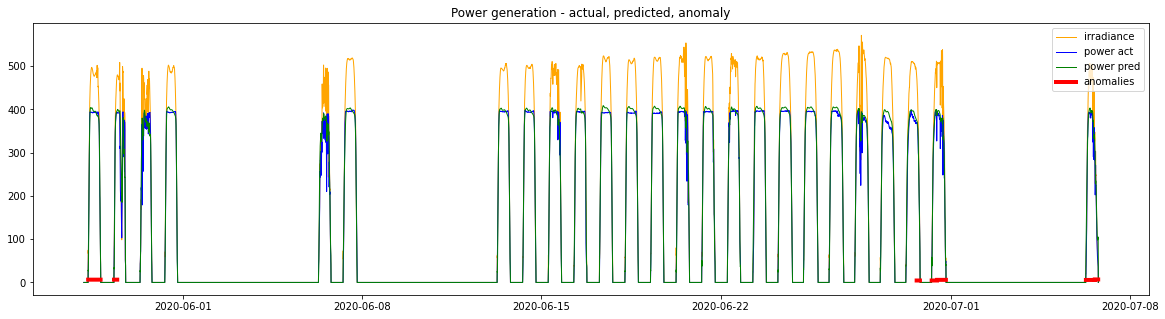

In [62]:
df_my = df_iii.loc['myentity'][2900:10000] #.reset_index()

#'GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2'

fig, ax = plt.subplots(1, 1, figsize=(20, 5), squeeze=False)
ax[0,0].plot(df_my.index, df_my['GlobalTiltedIrradiance_wm2']/2, lw=1, color='orange', label='irradiance')
ax[0,0].plot(df_my.index, df_my['Power_kW'], lw=1, color='blue', label='power act')
ax[0,0].set_title('Power generation - actual, predicted, anomaly')
ax[0,0].plot(df_my.index, df_my['pred_Power_kW'], lw=1, color='green', label='power pred')
#ax[1,0].set_title('Power generation - predicted')
ax[0,0].plot(df_my.index, df_my['anom_Power_kW'], lw=4, color='red', label='anomalies')
#ax[2,0].set_title('Power generation - anomalous')
ax[0,0].legend()

#df_iii[['Power_kW','pred_Power_kW','anom_Power_kW']].plot(figsize=(20,8))

In [56]:
error.anom_scores

NameError: name 'error' is not defined

In [216]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

#regressor = BayesRidgeRegressorExt(['GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2'], ['Power_kW'], degree=3)
#regressor = GBMRegressor(['GlobalHorizontalIrradiance_wm2','GlobalTiltedIrradiance_wm2','AmbientTemperature_C',
#                          'Inverter_Temperature_C','PanelTemperature_C'], ['Power_kW'])
#regressor = GBMRegressor(['GlobalTiltedIrradiance_wm2'], ['Power_kW'], learning_rate=0.1)
#spsi = GBMRegressor(['SPEED'], ['POWER'], learning_rate=0.1)
regressor = LSTM


et = regressor._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)

et.delete_existing_models = True
et.auto_train = True
regressor._entity_type = et
df_iii = regressor.execute(df=df_dl)

#df_iii = spsi.execute(df=df_input[0:300])

EngineLogging.configure_console_logging(logging.INFO)
df_input.describe()

2022-05-11T22:19:14.774 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-05-11T22:19:14.775 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.7.0
2022-05-11T22:19:14.775 DEBUG iotfunctions.util.__init__ Starting trace
2022-05-11T22:19:14.776 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_BayesRidgeRegressorExt_20220511201914
2022-05-11T22:19:14.776 DEBUG iotfunctions.util.__init__ auto_save None
2022-05-11T22:19:14.776 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-05-11T22:19:14.776 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-05-11T22:19:14.777 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_BAYESRIDGEREGRESSOREXT
Functions:
Granularities:
No schedules metadata
2022-05-11T22:19:14.777 DEBUG iotfunctions.anomaly.execute Execute BayesianRidgeRegres

,ROWID,AmbientTemperature_C,Inverter_Temperature_C,PanelTemperature_C,GlobalTiltedIrradiance_wm2,GlobalHorizontalIrradiance_wm2,Power_kW,Voltage_volt,Current_amp
count,12384.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000
mean,6192.500000,35.900701,40.352306,39.636061,407.995105,433.980542,165.518382,341.942900,249.271326
std,3575.097201,11.913746,14.790385,13.965175,452.449640,478.599213,179.991000,333.937525,271.857981
min,1.000000,13.876353,13.876353,13.876353,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3096.750000,24.413532,25.817285,25.817285,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6192.500000,38.000000,41.529053,40.783039,111.899414,122.943848,41.930908,608.078125,61.902588
75%,9288.250000,45.316456,52.749512,51.730957,958.146484,1015.601563,389.274414,668.476562,570.925781
max,12384.000000,64.000000,70.000000,70.530273,1213.953125,1302.406250,398.921875,784.773438,655.101562


In [168]:
df_iii.columns

Index(['AmbientTemperature_C', 'Inverter_Temperature_C', 'PanelTemperature_C',
       'GlobalTiltedIrradiance_wm2', 'GlobalHorizontalIrradiance_wm2',
       'Power_kW', 'Voltage_volt', 'Current_amp', 'predicted_Power_kW'],
      dtype='object')

<AxesSubplot:xlabel='datetime'>

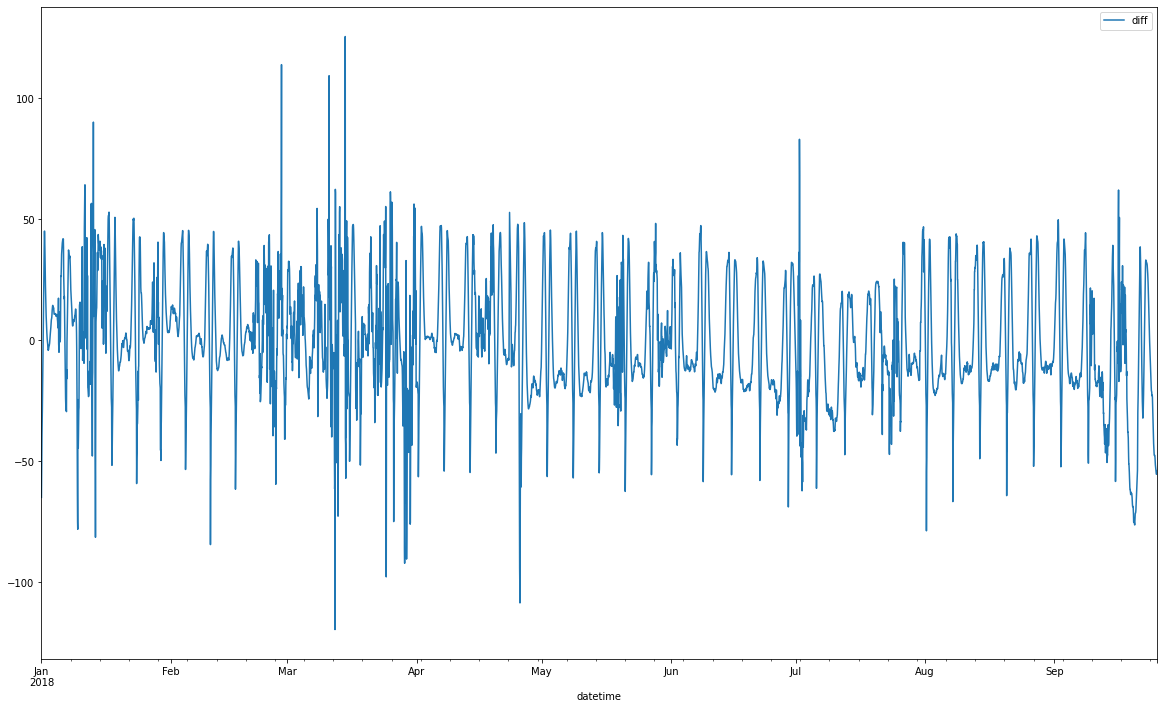

In [222]:
df_iii['diff'] = df_iii['Power_kW'] - df_iii['predicted_Power_kW']
df_iii.loc['myentity'][['diff']].plot(figsize=(20,12))